In [1]:
import functions as Q
import requests
import numpy as np
from scipy.linalg import expm
from skopt import BayesSearchCV
from skopt.space import Integer
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from scipy.signal import convolve
import time

# Initialize Data as a DataFrame
data_list = []

#Data = pd.DataFrame()
#initialize dataframe
#Data = pd.DataFrame(columns=['t', 'S', 'I', 'MOBid', 'MOAsk'])
#initialize parameters
n=5
N=20
counter = 0

while True:
    ask_prices, ask_volumes, ask_timestamps, bid_prices, bid_volumes, bid_timestamps, mid_price,ImbalanceRatio = Q.get_LOB(requests.get('https://api.kraken.com/0/public/Depth?pair=XBTUSD'))

    #if ask_timestamps[0] != bid_timestamps[0]:
     #   print('bid and ask timestamps are not the same')

    new_data = {'t': bid_timestamps[0], 'S': mid_price, 'I': ImbalanceRatio, 'MOBid':bid_prices[0], 'MOAsk': ask_prices[0]}

    data_list.append(new_data)

    # Increment the counter
    counter += 1

    # Every 25 iterations (every 5 seconds), run the Q function
    if counter % 25 == 0:
        print('running Q', counter)
        Data = pd.DataFrame(data_list)
        Qt= Q.make_Q(Data, n, N)
        if not np.isnan(Qt).any():
            break

    # Sleep for a while before fetching the next set of data
    time.sleep(.3)



running Q 25


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
c:\Users\Maxparizot\Documents\GitHub\TradeonQ\Code_2\functions.py:83: RuntimeWarning: invalid value encountered in divide
  G = C / H


running Q 50
running Q 75


c:\Users\Maxparizot\Documents\GitHub\TradeonQ\Code_2\functions.py:83: RuntimeWarning: divide by zero encountered in divide
  G = C / H


running Q 100
running Q 125
running Q 150
running Q 175
running Q 200
running Q 225
running Q 250
running Q 275
running Q 300
running Q 325
running Q 350


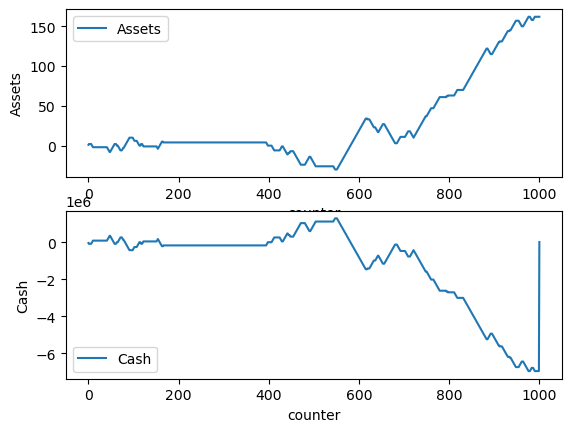

In [2]:
#trade on Q
import Kraken_websocket_API as K
import matplotlib.pyplot as plt

# Initialize the figure and two subplots for assets and cash
fig, (ax1, ax2) = plt.subplots(2, 1)

# Initialize two empty lists to store the history of assets and cash
assets_history = []
cash_history = []
debug_list= []


# Initialize trading variables
cash = 0     # Total cash
assets = 0   # Number of assets (stocks) held
counter = 0  #reset counter to 0

while True:
    ask_prices, ask_volumes, ask_timestamps, bid_prices, bid_volumes, bid_timestamps, mid_price,ImbalanceRatio = Q.get_LOB(requests.get('https://api.kraken.com/0/public/Depth?pair=XBTUSD'))

    #calculate 
    new_data = {'t': bid_timestamps[0], 'S': mid_price, 'I': ImbalanceRatio, 'MOBid':bid_prices[0], 'MOAsk': ask_prices[0]}
    data_list.append(new_data)
    #get states
    rho, DS= K.getstates(pd.DataFrame(data_list[-N-1:]), n, N)

    # Get row and column indices for the current state in the Q matrix - subtract 1 because Python is 0-indexed
    row = rho + n * (DS + 1) -1
    downColumn = rho -1
    upColumn = rho + 2 * n  -1

    debug_data = {'RHO': rho, 'ds': DS, 'ROW': row, 'DOWNCOLUMN':downColumn, 'UPCOLUMN':upColumn, 'DOWNPROB':Qt[row, downColumn], 'UPPROB':Qt[row, upColumn]}

    debug_list.append(new_data)
    # If predicting a downward price move
    if Qt[row, downColumn] > 0.5:
        cash = cash + bid_prices[0] # Sell
        assets = assets - 1

    # If predicting an upward price move
    elif Qt[row, upColumn] > 0.5:
        cash = cash - ask_prices[0] # Buy
        assets = assets + 1

    # Increment the counter
    counter += 1
    data_list = data_list[-N*3:]
    assets_history.append(assets)
    cash_history.append(cash)
    if counter == 1000:

        if assets > 0:
            cash = cash + assets * bid_prices[0]  # Sell off remaining assets
        elif assets < 0:
            cash = cash + assets * ask_prices[0] # Buy back remaining short positions
        
        assets_history.append(assets)
        cash_history.append(cash)
        break

    # Sleep for a while before fetching the next set of data
    time.sleep(.3)



# Initialize the line objects for assets and cash
line1 = ax1.plot(assets_history, label='Assets')
line2 = ax2.plot(cash_history, label='Cash')

# Set the labels for the plots
ax1.set_xlabel('counter')
ax2.set_xlabel('counter')
ax1.set_ylabel('Assets')
ax2.set_ylabel('Cash')

# Draw the legend
ax1.legend()
ax2.legend()

plt.ion()
plt.show()

In [1]:
rho, DS= K.getstates(pd.DataFrame(data_list[-N-1:]), n, N)
print('rho', rho)
print('DS', DS)

NameError: name 'K' is not defined